In [1]:
pip install librosa matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import splitfolders


In [25]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

In [4]:
input_dir = "/Users/shounakkelkar/Downloads/Data/genres_original"
output_dir = "/Users/shounakkelkar/Desktop/genreimages1"
os.makedirs(output_dir, exist_ok = True)

In [43]:
def convertspectrogram(audio_dir, output_dir):
    for genre_folder in os.listdir(audio_dir):
        genre_path = os.path.join(audio_dir, genre_folder)
        genre_output_path = os.path.join(output_dir, genre_folder)

        # Create genre specific output directory
        os.makedirs(genre_output_path, exist_ok = True)

        if os.path.isdir(genre_path):
            # Loop every audio file in every file 
            for filename in os.listdir(genre_path):
                if filename.endswith('.wav'):
                    file_path = os.path.join(genre_path, filename)
                    try: 
                        # Load audio file
                        y, sr = librosa.load(file_path)

                        # Load audio file only 30 second 
                        # y, sr = librosa.load(file_path, duration = 30)
    
                        # Generate the spectrogram
                        S = librosa.feature.melspectrogram(y = y, sr = sr, n_mels = 128, fmax = 8000)
    
                        # Converting to Decibel Scale
                        S_dB = librosa.power_to_db(S, ref = np.max)
                        
                        # Plotting the Mel-Spectrogram
                        plt.figure(figsize = (10,4))
                        librosa.display.specshow(S_dB, sr = sr, fmax = 8000, x_axis = None, y_axis = None)
                        plt.tight_layout()
    
                        # Save the spectrogram as an image file
                        output_filename = os.path.join(genre_output_path, f'{os.path.splitext(filename)[0]}.png')
                        plt.savefig(output_filename)
                        plt.close()
                    except Exception as e:
                        # Print the error and skip
                        print(f"Skipping {filename}: Unsupported or corrupted file. Error: {e}")

In [45]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [ ]:
convertspectrogram(input_dir, output_dir)


In [11]:
import splitfolders
splitfolders.ratio("/Users/shounakkelkar/Desktop/genreimages1", output="/Users/shounakkelkar/Desktop/genreimages2",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 999 files [00:00, 1336.72 files/s]


In [19]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen=ImageDataGenerator(
    rescale=1./255,
)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    '/Users/shounakkelkar/Desktop/genreimages2/train',
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical',

)

validation_generator = val_datagen.flow_from_directory(
    '/Users/shounakkelkar/Desktop/genreimages2/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',    
)

Found 799 images belonging to 11 classes.
Found 200 images belonging to 11 classes.


In [80]:
import kerastuner as kt
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers
from keras_tuner import RandomSearch
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(
    filters = hp.Int('c1',min_value = 32, max_value = 128, step =32),
    kernel_size = (3,3),
    ))
    model.add(layers.LeakyReLU(alpha = hp.Float('leakyalpha1',0.1,0.5,step = 0.1)))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(
    filters = hp.Int('c2',min_value = 32, max_value = 128, step =32),
    kernel_size = (3,3),
    ))
    model.add(layers.LeakyReLU(alpha = hp.Float('leakyalpha2',0.1,0.5,step = 0.1)))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(
    filters = hp.Int('c3',min_value = 64, max_value = 256, step =64),
    kernel_size = (3,3),
    ))
    model.add(layers.LeakyReLU(alpha = hp.Float('leakyalpha3',0.1,0.5,step = 0.1)))
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64)
    ))
    model.add(layers.LeakyReLU(alpha=hp.Float('leakyalpha4', 0.1, 0.5, step=0.1)))
    model.add(layers.Dense(11, activation='softmax'))  
    adam_opt = optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG'))
    model.compile(optimizer=adam_opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  
    max_trials=5,             
    executions_per_trial=1,
    
)
tuner.search(train_generator, 
             epochs=40, 
             validation_data=validation_generator, 
             )

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


    

Trial 5 Complete [00h 16m 39s]
val_accuracy: 0.6949999928474426

Best val_accuracy So Far: 0.699999988079071
Total elapsed time: 02h 49m 05s
Best Hyperparameters: {'c1': 96, 'leakyalpha1': 0.2, 'c2': 128, 'leakyalpha2': 0.5, 'c3': 64, 'leakyalpha3': 0.5, 'dense_units': 128, 'leakyalpha4': 0.5, 'learning_rate': 0.0003484786063390684}


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 96)   │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 222, 222, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 109, 109, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 52, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,726,539 (21.85 MB)

 Trainable params: 5,726,539 (21.85 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers


#defined model below
model = models.Sequential()
model.add(layers.Conv2D(96, (3, 3), input_shape=(224, 224, 3)))
model.add(layers.LeakyReLU(negative_slope=0.2))
model.add(layers.Dropout(0.25))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.LeakyReLU(negative_slope=0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.LeakyReLU(negative_slope=0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128))
model.add(layers.LeakyReLU(negative_slope=0.5))
model.add(layers.Dense(11, activation='softmax'))
#optimizer rate from keras
adam_opt = optimizers.Adam(learning_rate=0.0003484786063390684)
model.compile(optimizer=adam_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [84]:
history=model.fit(
    train_generator,
    epochs=100,  
    validation_data=validation_generator
)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.1481 - loss: 2.7811 - val_accuracy: 0.3050 - val_loss: 2.0728
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.3288 - loss: 1.9458 - val_accuracy: 0.2950 - val_loss: 2.0516
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.4256 - loss: 1.6258 - val_accuracy: 0.3000 - val_loss: 1.8653
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5044 - loss: 1.5512 - val_accuracy: 0.4250 - val_loss: 1.6589
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6332 - loss: 1.1169 - val_accuracy: 0.5300 - val_loss: 1.3990
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.6735 - loss: 0.9637 - val_accuracy: 0.5300 - val_loss: 1.3488
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.7269 - loss: 0.7961 - val_accuracy: 0.4800 - val_loss: 1.4937
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.7439 - loss: 0.6977 - val_accuracy: 0.5750 - v

In [86]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 96)   │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 222, 222, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 222, 222, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 111, 111, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 128)  │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 109, 109, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 52, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,179,619 (65.54 MB)

 Trainable params: 5,726,539 (21.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,453,080 (43.69 MB)

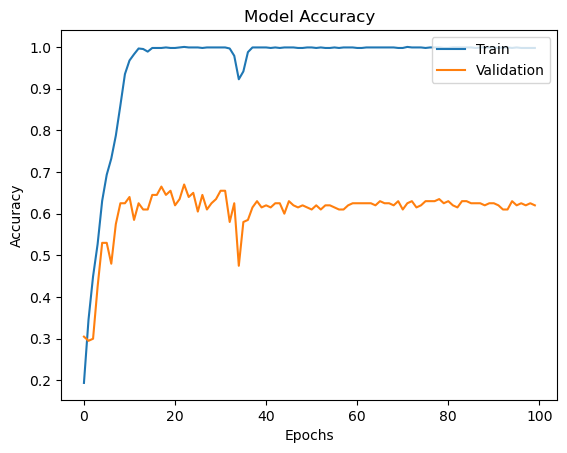

In [94]:
import matplotlib.pyplot as plt 
from pylab import *
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


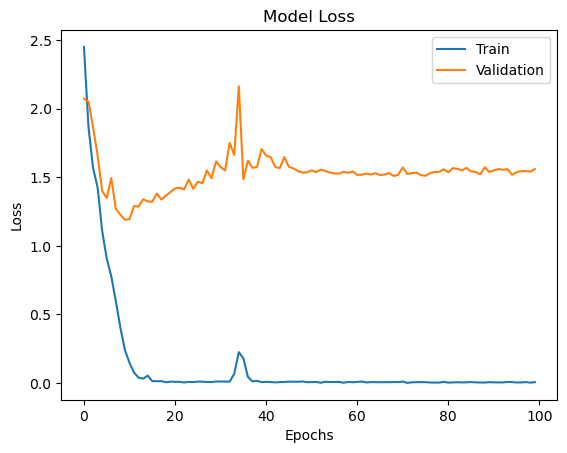

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()